# Задание:

Необходимо взять (или сгенерировать самому) датасет, в котором для достаточно большой целевой аудитории (абоненты или лояльные клиенты) представлены еженедельные метрики (тут на ваш выбор). Например, в течение 2-3 месяцев вы собирали, накапливали ваши данные. Далее используйте различные техники для проверки распределений ваших метрик (1 метрика - непрерывная, 2-я дискретная [можно взять бинарную]).

# Пример: 

У меня есть 1 миллион юзеров Киона. Собираю по ним метрики за 12 недель (суммарное время просмотра за каждую неделю и флаг просмотра хотя бы одного фильма из какой-то категории). Далее сравниваем распределения метрик в динамике по разным неделям и делаем выводы о появлении отклонения (распределение начало изменяться или нет). Можно использовать техники, предложенные на занятии.


# Выбранный датасет

В датасете собраны данные по пользователям и объектам (сериалы/фильмы), а также по их взаимодействиям (просмотр контента пользователем) из онлайн-кинотеатра Kion. Данные по просмотру контента собраны за ~6 месяцев, с 2021-03-13 по 2021-08-22  включительно, и разбавлены случайным шумом. ID пользователей и контента анонимизированы.

Статистика по датасету:

* 840к пользователей
* 16к объектов
* 5.5кк взаимодействий


## users.csv
В данном файле содержится информация о пользователях:

* user_id - ID пользователя
* age - возрастная группа пользователя, строка вида "M_N"

1) 18_24 - от 18 до 24 лет включительно
2) 25_34 - от 25 до 34 лет включительно
3) 35_44 - от 35 до 44 лет включительно
4) 45_54 - от 45 до 54 лет включительно
5) 55_64 - от 55 до 64 лет включительно
6) 65_inf - от 65 и старше
* sex - пол пользователя
1) М - мужчина
2) Ж - женщина
* income - доход пользователя, строка вида "M_N"

1) income_0_20
2) income_20_40
3) income_40_60
4) income_60_90  
5) income_90_150
6) income_150_inf
* kids_flg - флаг "наличие ребенка"


# items.csv

В данном файле содержится информация об объектах (фильмы/сериалы):

* item_id - ID контента
* content_type - Тип контента (фильм, сериал)
* title - Название на русском
* title_orig - Название оригинальное
* genres - Жанры из источника (онлайн-кинотеатры)
* countries - страны
* for_kids - флаг "контент для детей"
* age_rating - возрастной рейтинг
* studios - студии
* directors - директора
* actors - актеры
* keywords - ключевые слова
* description - описание


## interactions.csv
В данном файле содержится информация о взаимодействиях пользователей с контентом:

* user_id - ID пользователя
* item_id - ID контента
* last_watch_dt - Дата последнего просмотра
* total_dur - Общая продолжительность всех просмотров данного контента в секундах
* content_type - Тип контента (фильм, сериал)

# Непрерывная метрика

1) Для непрерывной метрики выберу **среднюю продолжительность просмотра контента за неделю (в секундах)**

Она позволит мне понять как меняется поведение пользователей (их вовлеченность) каждую неделю: растет среднее время просмтров, падает или не изменятеся. Так, если среднее время растет - можем говорить о повышении интереса к нашей платформе. И наоборот, если убывает, то интерес снижается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

In [2]:
users = pd.read_csv("users.csv")
items = pd.read_csv("items.csv")
interactions = pd.read_csv("interactions.csv")

In [3]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [4]:
interactions.isnull().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      828
dtype: int64

In [5]:
print(interactions.dtypes)

user_id            int64
item_id            int64
last_watch_dt     object
total_dur          int64
watched_pct      float64
dtype: object


In [6]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [7]:
items.isnull().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [8]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [9]:
users.isnull().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

Для моего дальнейшего анализа мне нужны: content_type и total_dur. NaN нигде нет, поэтому менять датасет не нужно.

Сначала разсплитую last_watch_dt на недели с помощью методов и атрибутов pandas

* .dt - аксессор pandas, который предоставляет доступ к методам обработки данных datetime

* .isocalendar() - возвращает ISO-календарные компоненты даты: год, номер недели (week), и номер дня недели. Например, isocalendar() для даты 2023-01-10 вернёт (2023, 2, 2) (год: 2023, неделя: 2, день недели: вторник).

* .week -  берёт только номер недели из результата isocalendar()

In [10]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])
interactions["week"] = interactions["last_watch_dt"].dt.isocalendar().week

In [11]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct,week
0,176549,9506,2021-05-11,4250,72.0,19
1,699317,1659,2021-05-29,8317,100.0,21
2,656683,7107,2021-05-09,10,0.0,18
3,864613,7638,2021-07-05,14483,100.0,27
4,964868,9506,2021-04-30,6725,100.0,17
...,...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0,32
5476247,546862,9673,2021-04-13,2308,49.0,15
5476248,697262,15297,2021-08-20,18307,63.0,33
5476249,384202,16197,2021-04-19,6203,100.0,16


# Непрерывная метрика

Для проверки распределения по неделям буду использовать:

* Критерий Колмогорова - Смирнова
* Дивергенцию Кульбака - Лейблера
* PSI
* Adversarial validation

Мне нужно для каждого пользователя посчитать среднее время просмотра (total_dur) для каждой недели. И потом посмотреть как эти распределения для каждой недели идут. То есть у меня будет для каждой недели распределение среднего времени просмотра по каждому пользователю.

Для этого сгрупппирую данные в таблице interactions по user_id и week, чтобы вычислить среднее значение total_dur для каждого пользователя в каждой неделе

In [12]:
#  для каждого пользователя за каждую неделю создаю группу строк и считаю по этому среднее
interactions_grouped = interactions.groupby(['user_id', 'week'])['total_dur'].mean().reset_index()
interactions_distributions = interactions_grouped.groupby('week')['total_dur'].apply(list)

# Критерий Колмогорова - Смирнова

In [13]:
res = []
weeks = sorted(interactions_distributions.index)

for i in range(1, len(weeks)):
    week_n = weeks[i - 1]
    week_n1 = weeks[i]
    
    dist1 = interactions_distributions[week_n]
    dist2 = interactions_distributions[week_n1]

    ks_stat, p_value = ks_2samp(dist1, dist2)
    diff = "есть отличия" if p_value < 0.05 else "нет отличий"
    res.append({
        'неделя_n': week_n,
        'неделя_n+1': week_n1,
        'ks_stat': ks_stat,
        'p_value': p_value,
        'Различия': diff
    })

res_data = pd.DataFrame(res)
print(res_data)

# Если p-value < 0.05, то распределения статистически значимо различаются

    неделя_n  неделя_n+1   ks_stat        p_value      Различия
0         10          11  0.055246   2.501093e-33  есть отличия
1         11          12  0.028179   1.104458e-14  есть отличия
2         12          13  0.007049   2.554229e-01   нет отличий
3         13          14  0.033494   9.454403e-21  есть отличия
4         14          15  0.013381   1.225860e-03  есть отличия
5         15          16  0.050999   1.357040e-58  есть отличия
6         16          17  0.040136   9.964272e-49  есть отличия
7         17          18  0.024223   2.518188e-18  есть отличия
8         18          19  0.007307   4.448977e-02  есть отличия
9         19          20  0.011296   1.869718e-04  есть отличия
10        20          21  0.019799   7.806035e-14  есть отличия
11        21          22  0.007771   9.351744e-03  есть отличия
12        22          23  0.041072   2.662927e-78  есть отличия
13        23          24  0.203427   0.000000e+00  есть отличия
14        24          25  0.131255   0.0

Итак, видно, что почти каждое распределение отличается от предыдущего, кроме двух недель: 12 и 13. Из графика ниже, на мой взгляд, визуально 13 сильно от 12 отличается, но тест Колмогорова - Смирнова не зафиксировал статзначимых различий.

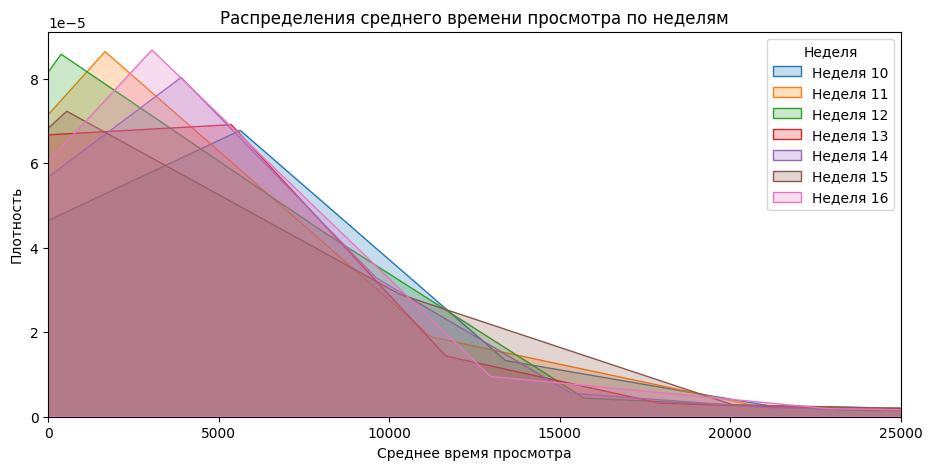

In [14]:
plt.figure(figsize=(11, 5))
for week in weeks[0:7]:
    sns.kdeplot(interactions_distributions[week], label=f"Неделя {week}", fill=True)

plt.title("Распределения среднего времени просмотра по неделям")
plt.xlabel("Среднее время просмотра")
plt.ylabel("Плотность")
plt.xlim(0, 25000)
plt.legend(title="Неделя")
plt.show()

Проверю через другой метод:

# Дивергенция Кульбака - Лейблера

In [15]:
def div_KL(p, q):
    
    # p и q распределения веротяности
    p = np.array(p)
    q = np.array(q)
    
    # нормализую
    p = p / p.sum()
    q = q / q.sum()
    
    nonzero = (p > 0) & (q > 0)
    p = p[nonzero]
    q = q[nonzero]
    
    return np.sum(p * np.log(p / q))

res_kl = []

for i in range(1, len(weeks)):
    week_n = weeks[i - 1]
    week_n1 = weeks[i]
    
    dist1 = interactions_distributions[week_n]
    dist2 = interactions_distributions[week_n1]

    hist1, bins1 = np.histogram(dist1, bins=30, density=True)
    hist2, bins2 = np.histogram(dist2, bins=30, density=True)
    
    kl_stat = div_KL(hist1, hist2)
    
    res_kl.append({
        'неделя_n': week_n,
        'неделя_n+1': week_n1,
        'kl_stat': kl_stat,
    })

res_kl_data = pd.DataFrame(res_kl)
print(res_kl_data)

    неделя_n  неделя_n+1   kl_stat
0         10          11  0.002149
1         11          12  0.000789
2         12          13  0.000795
3         13          14  0.000327
4         14          15  0.001786
5         15          16  0.001229
6         16          17  0.000486
7         17          18  0.000938
8         18          19  0.003988
9         19          20  0.002689
10        20          21  0.013694
11        21          22  0.008946
12        22          23  0.001179
13        23          24  0.004438
14        24          25  0.001159
15        25          26  0.001131
16        26          27  0.007606
17        27          28  0.000215
18        28          29  0.001117
19        29          30  0.059901
20        30          31  0.011354
21        31          32  0.000200
22        32          33  0.002076


В лекции говорилось, что если kl_stat = 0, то распределения одинаковы. У меня нигде дивергенция 0 не равна. Значит, есть различия между всеми распределениями. И даже между 12 и 13.

Теперь через PSI (это как бы искусственно симметричная дивергенция Кульбака - Лейбница)

# PSI

In [16]:
bins = np.linspace(interactions_grouped['total_dur'].min(), interactions_grouped['total_dur'].max(), 21)

def psi_func(expected, actual, bins):

    expected_probabilities = np.histogram(expected, bins=bins, density=True)[0]
    actual_probabilities = np.histogram(actual, bins=bins, density=True)[0]
    
    expected_probabilities = expected_probabilities / expected_probabilities.sum()
    actual_probabilities = actual_probabilities / actual_probabilities.sum()

    expected_probabilities = np.maximum(expected_probabilities, 1e-10)
    actual_probabilities = np.maximum(actual_probabilities, 1e-10)
    
    psi = np.sum((expected_probabilities - actual_probabilities) * np.log(expected_probabilities / actual_probabilities))
    return psi

psi_res = []

for i in range(1, len(weeks)):
    week_n = weeks[i - 1]
    week_n1 = weeks[i]

    dist1 = interactions_grouped[interactions_grouped['week'] == week_n]['total_dur']
    dist2 = interactions_grouped[interactions_grouped['week'] == week_n1]['total_dur']
    
    psi_value = psi_func(dist1, dist2, bins)
    
    psi_res.append({
        'неделя_n': week_n,
        'неделя_n+1': week_n1,
        'PSI': psi_value
    })

psi_data = pd.DataFrame(psi_res)
print(psi_data)

    неделя_n  неделя_n+1       PSI
0         10          11  0.000000
1         11          12  0.000000
2         12          13  0.000000
3         13          14  0.000000
4         14          15  0.000000
5         15          16  0.000000
6         16          17  0.000000
7         17          18  0.000000
8         18          19  0.000000
9         19          20  0.000000
10        20          21  0.000288
11        21          22  0.000288
12        22          23  0.000000
13        23          24  0.000000
14        24          25  0.000000
15        25          26  0.000000
16        26          27  0.000087
17        27          28  0.000087
18        28          29  0.000000
19        29          30  0.000147
20        30          31  0.000147
21        31          32  0.000000
22        32          33  0.000066


Все значения PSI равны 0.1, что говорит о том, что тест не нашел статистически значимых различий между распределениями. И еще это указывает на то, что распределения остаются стабильными, а пропорции в бинах не изменяются сильно между неделями.

# Вывод по непрерывному распределению

После трех тестов результаты получились очень разные:

1. Тест Колмогорова-Смирнова показал, что распределения отличаются между собой, за исключением 12 и 13 недель. Этот тест ищет наибольшие отклонения между двумя распределениями, и, видимо, он заметил различия в их форме (может быть, из-за смещения).

2. Дивергенция Кульбака-Лейблера показала, что различия есть между всеми неделями, но они идут в одном направлении. Например, 10 неделя отличается от 11, 11 от 12 и так далее, но не наоборот. Это может значить, что распределения изменяются постепенно каждую неделю. Этот тест чувствителен к таким изменениям, а сам метод оценивает, насколько сильно изменяется распределение. Но стоит заметить, что этот тест не учитывает изменения в обратную сторону.

А вот PSI учитывает в обе стороны, но ...

3. PSI дал совсем другой результат - различий между неделями нет. PSI чувствителен к изменениям в пропорциях значений в заранее определенных бинах. Если данные для каждой недели в этих бинах в целом остаются похожими, даже если форма распределения или экстремальные значения меняются, PSI не покажет значительных изменений.

Но вообще каждый тест анализирует разные аспекты распределений. **Тест Колмогорова-Смирнова** ищет наибольшие отклонения между функциями распределений, и поэтому он чувствителен к изменениям в форме или выбросам. **Дивергенция Кульбака-Лейблера** анализирует различия в вероятностных распределениях и скорее всего, чувствительна к постепенным изменениям между соседними неделями. **PSI** оценивает только изменения в пропорциях по бинам и не так чувствителен к изменениям в форме распределений или выбросам, если пропорции в бинах остаются похожими.

# Дискретная метрика


2) Для дискретной метрики выберу кол-во фильмов, которые пользователь посмотрел за неделю. Точнее посмотрел он более трех фильмов or три, или нет

content_type = "фильм"

Она позволит мне понять: есть ли интерес на нашей платформе к фильмам. Он уменьшается, растет или не изменяется. Так можно будет менять рекомендации (в дальнейших исследованиях)

In [17]:
interactions = pd.merge(interactions, items[['item_id', 'content_type']], on='item_id', how='left')
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct,week,content_type
0,176549,9506,2021-05-11,4250,72.0,19,film
1,699317,1659,2021-05-29,8317,100.0,21,film
2,656683,7107,2021-05-09,10,0.0,18,series
3,864613,7638,2021-07-05,14483,100.0,27,series
4,964868,9506,2021-04-30,6725,100.0,17,film
...,...,...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0,32,series
5476247,546862,9673,2021-04-13,2308,49.0,15,film
5476248,697262,15297,2021-08-20,18307,63.0,33,series
5476249,384202,16197,2021-04-19,6203,100.0,16,film


In [18]:
films = interactions[interactions['content_type'] == 'film']

films_count = films.groupby(['user_id', 'week']).size()

films_count = (films_count >= 3).astype(int)

films_count.name = 'watched_more_than_3'

interactions = interactions.merge(films_count, 
                                  left_on=['user_id', 'week'], 
                                  right_index=True, 
                                  how='left')
interactions['watched_more_than_3'] = interactions['watched_more_than_3'].fillna(0)

interactions['watched_more_than_3'] = interactions['watched_more_than_3'].astype(int)

interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct,week,content_type,watched_more_than_3
0,176549,9506,2021-05-11,4250,72.0,19,film,1
1,699317,1659,2021-05-29,8317,100.0,21,film,1
2,656683,7107,2021-05-09,10,0.0,18,series,0
3,864613,7638,2021-07-05,14483,100.0,27,series,0
4,964868,9506,2021-04-30,6725,100.0,17,film,0
...,...,...,...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0,32,series,0
5476247,546862,9673,2021-04-13,2308,49.0,15,film,1
5476248,697262,15297,2021-08-20,18307,63.0,33,series,0
5476249,384202,16197,2021-04-19,6203,100.0,16,film,1


Выше я попробовала сделать KL дивергенцию сама, потому что было непрерывное распределение (я прочитала, что можно через интегралы или KDE). KDE мне понятнее, но вообще она для дискретных распределений есть в библиотеке scipy

In [25]:
from scipy.special import kl_div

week_dist = interactions.groupby(['week', 'watched_more_than_3']).size().unstack(fill_value=0)
week_dist_norm = week_dist.div(week_dist.sum(axis=1), axis=0)

def kl_divergence(p, q):
    p = p[p > 0]
    q = q[q > 0]
    return np.sum(kl_div(p, q))

kl_results = []

for week in range(1, len(week_dist_norm)):
    p = week_dist_norm.iloc[week - 1]
    q = week_dist_norm.iloc[week]
    
    kl_val = kl_divergence(p, q)
    kl_results.append((week_dist_norm.index[week - 1], week_dist_norm.index[week], kl_val))

kl_df = pd.DataFrame(kl_results, columns=['Неделя n', 'Неделя n + 1', 'КЛ'])

print(kl_df)


    Неделя n  Неделя n + 1            КЛ
0         10            11  4.907159e-02
1         11            12  3.940186e-04
2         12            13  1.134618e-04
3         13            14  1.808275e-05
4         14            15  1.737229e-05
5         15            16  5.202603e-03
6         16            17  5.488863e-04
7         17            18  3.674749e-04
8         18            19  2.124956e-03
9         19            20  7.600881e-04
10        20            21  9.238220e-06
11        21            22  1.576940e-04
12        22            23  8.592463e-05
13        23            24  2.721351e-03
14        24            25  1.023603e-02
15        25            26  7.411442e-03
16        26            27  3.119215e-03
17        27            28  1.896286e-03
18        28            29  6.170012e-04
19        29            30  1.741066e-05
20        30            31  8.532710e-05
21        31            32  8.226892e-07
22        32            33  1.873105e-04


Итак, у меня очень маленькая дивергенция $\rightarrow 0$, поэтому можно сказать, что разницы в распределениях нет, то есть пользователи смотрят фильмы с одинаковой частотой все недели. Хотя вот для недель 10-11, 24 - 25 дивергенция больше всего, поэтому можно заподозрить здесь расхождения

Дополнительно проверю через 

# Adversarial validation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

week_count = interactions[['week', 'watched_more_than_3']]

roc_auc_results = []

for i in range(len(weeks) - 1):
    week_1 = weeks[i]
    week_2 = weeks[i + 1]
    
    week_n = week_count[week_count['week'] == week_1]
    week_n_1 = week_count[week_count['week'] == week_2]
    
    X = pd.concat([week_n[['watched_more_than_3']], week_n_1[['watched_more_than_3']]], axis=0)
    y = pd.concat([pd.Series([0] * len(week_n)), pd.Series([1] * len(week_n_1))], axis=0)

    X = X.values.reshape(-1, 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression()
    model.fit(X_scaled, y)
    
    y_pred = model.predict_proba(X_scaled)[:, 1]
    roc_auc = roc_auc_score(y, y_pred)
    
    roc_auc_results.append((week_1, week_2, roc_auc))

roc_auc_df = pd.DataFrame(roc_auc_results, columns=['Неделя n', 'Неделя n+1', 'ROC_AUC'])

print(roc_auc_df)

    Неделя n  Неделя n+1   ROC_AUC
0         10          11  0.578082
1         11          12  0.506983
2         12          13  0.503748
3         13          14  0.501497
4         14          15  0.501467
5         15          16  0.525486
6         16          17  0.508282
7         17          18  0.506771
8         18          19  0.516295
9         19          20  0.509739
10        20          21  0.501073
11        21          22  0.504429
12        22          23  0.503270
13        23          24  0.518328
14        24          25  0.535721
15        25          26  0.530343
16        26          27  0.519706
17        27          28  0.515394
18        28          29  0.508771
19        29          30  0.501473
20        30          31  0.503259
21        31          32  0.500320
22        32          33  0.504823


ROC_AUC также подтвердил, что различий нет, так как он близок к 0.5. И самое наибольшее различие между неделями 10-11, что я и подозревала через KL дивергенцию